# YOUR NAME

This notebook is a template showing you how to use some tools that will be useful for problem set 5.

The tools are:
1. Qmod: an implementation of the q-Model as a class in python. This is used to obtain phase diagrams.
2. Dolo: a general purpose tool used to represent and solve economic models. This is used to compute optimal responses.

The use of both tools will make us have to handle two representations of our problems, one as a Qmod object, and one as a Dolo model.

Start by loading the tools we will be using.

In [1]:
# ! pip install dolo==0.4.9.12

In [2]:
# Preamble: import the packages we will be using

# Usual packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from dolo import *
import dolo.algos.perfect_foresight as pf
import pandas as pd

# Import the Qmod python code from external file

# Since the Qmod class is in other folder we need to
# change the path.
import sys
sys.path.append('../')
from Qmod import Qmod

    pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


I then define a function that takes two Qmod objects and plots their phase diagrams in the same figure.

In [3]:
def phase_diagrams(mod1,mod2,k_min,k_max,npoints = 300):
    """
    Draws the phase diagram of the Qmodel under two different sets of
    parameter values in the same figure, and returns it.

    Parameters:
        - mod1          : Qmod object representing the first set of parameter values.
        - mod1          : Qmod object representing the second set of parameter values.
        - [k_min,k_max] : limits for the value of capital in the phase diagrams.
        - npoints       : number of points in the capital grid to be used for phase
                          diagram plots.
    """

    # Create a figure
    fig, ax = plt.subplots()

    # Plot the loci of the pre and post-change models.
    k_range = np.linspace(k_min,k_max,npoints)
    mods = [mod1,mod2]
    colors = ['r','b']
    labels = ['Mod. 1','Mod. 2']
    for i in range(2):

        # Plot k0 locus
        ax.plot(k_range,mods[i].P*np.ones(npoints),
                 linestyle = '--', color = colors[i],label = labels[i] + ' loci')
        # Plot lambda0 locus
        ax.plot(k_range,[mods[i].lambda0locus(x) for x in k_range],
                 linestyle = '--', color = colors[i])
        # Plot steady state
        ax.plot(mods[i].kss,mods[i].P,marker = '*', color = colors[i])
        
        # Plot stable arm
        stab_arm = [mods[i].findLambda(k0 = x, k1 = mods[i].k1Func(x)) for x in k_range]
        ax.plot(k_range, stab_arm, linestyle = '-', color = colors[i], label = labels[i] + ' stable arm.')

    return(ax)

Now I create a base model parametrization.

In [4]:
# Base parameters

# Discount factor and return factor
beta = 0.98
R = 1/beta

# Tax rate
tau = 0.05

# Share of capital in production
alpha = 0.33

# Adjustment costs
omega = 1

# Investment tax credit
zeta = 0

# Depreciation rate
delta = 0.1

# Technological factor
psi = 1

And create the objects representing the model. First in Qmod:

In [5]:
## Qmod python class

# Create the object.
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
# Solve to find the steady state and policy rule.
Qmodel.solve()

    Capital diverged at step 2. Holding capital constant.
    Capital diverged at step 3. Holding capital constant.
    Capital diverged at step 4. Holding capital constant.
    Capital diverged at step 9. Holding capital constant.
    Could not find k2 solution at step 6: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    Could not find k2 solution at step 13: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    Capital diverged at step 11. Holding capital constant.
    Capital diverged at step 15. Holding capital constant.
    Capital diverged at step 24. Holding capital constant.
    Could not find k2 solution at step 16: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    Could not find k2 solution at step 19: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    

Then in Dolo.

There is an important difference. The implementation in Dolo treats the interest rate, technological factor, tax rate, and investment tax credit as not parameters but exogenous variables subject to change.

In [6]:
## Dolo

# First import the external file with the model description.
QDolo = yaml_import("../Dolo/Q-model.yaml")

# Then replace the default parameters with our desired ones.
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)

#############
# IMPORTANT #
#############

# We do not pass R, psi, tau, or itc because they are handled not as parameters
# but exogenous variables that can change over time. (see below)

    Impossible to evaluate expression


## Dynamic response example: changes in productivity.

I now give an example of how to use Dolo to solve for the optimal behavior of the firm.
The basic idea is:
1. We will create a path for the exogenous variables of the model.
2. Dolo assumes that this path is announced to the firm at the first time period, and it computes the optimal dynamics according to these paths.

In [7]:
# Set up the basic features of the simulation

# Total simulation time
T = 100
# Initial level of capital
k0 = Qmodel.kss

,R,tau,itc_1,psi
0,1.020408,0.05,0,1.0
1,1.020408,0.05,0,1.0
2,1.020408,0.05,0,1.0
3,1.020408,0.05,0,1.2
4,1.020408,0.05,0,1.2


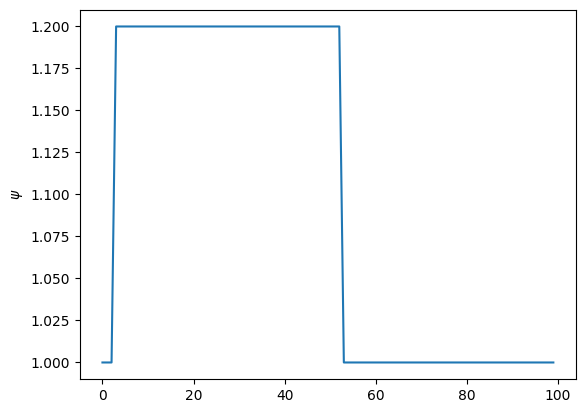

In [8]:
# Design the shock:

# for this example, I am assuming that productivity increases and then
# goes back to the original level.

psi_high = 1.2
Psi_sequence = np.array([psi]*3+
                        [psi_high]*50+
                        [psi]*(T-3-50))
# Check the pattern of the shock
plt.figure()
plt.plot(Psi_sequence)
plt.ylabel('$\psi$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'tau':[tau]*T,
                     'itc_1':[zeta]*T,
                     'psi':Psi_sequence})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [9]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.08584546286337591 | 0
	> 2 | 0.02893974202784777 | 0
	> 3 | 0.0054883208824727525 | 0
	> 4 | 0.0002628168846781076 | 0
	> 5 | 6.066963531559111e-07 | 0
> System was solved after iteration 5. Residual=6.066963531559111e-07


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,4.298990,0.653092,1.618121,0.124211,0.98,0.005794,0.645708,0.051918,0.051918,-0.006539,1.051918,1.051918,1.020408,0.05,0.0,1.0
2,4.522183,0.702993,1.645375,0.120069,0.98,0.006953,0.695747,0.055454,0.055454,-0.007083,1.055454,1.055454,1.020408,0.05,0.0,1.0
3,4.772958,0.675014,2.009931,0.138966,0.98,0.004095,0.665527,0.041425,0.041425,-0.005000,1.041425,1.041425,1.020408,0.05,0.0,1.2
4,4.970676,0.651641,2.037034,0.135237,0.98,0.002403,0.640964,0.031097,0.031097,-0.003593,1.031097,1.031097,1.020408,0.05,0.0,1.2
5,5.125250,0.632612,2.057724,0.132491,0.98,0.001407,0.621338,0.023430,0.023430,-0.002618,1.023430,1.023430,1.020408,0.05,0.0,1.2


# IMPORTANT

Because of the way the model is implemented, it does not keep track of $\lambda_t$ or $ITC_t$, but  $\lambda_{t+1}$ and $ITC_{t+1}$ instead. 

Thus, lambda_1 in row 1 corresponds to $\lambda_2$. Same with the ITC.

# Plots

Now we can use Qmod to plot the phase diagrams and add the optimal dynamics that we just found.

    Capital diverged at step 2. Holding capital constant.
    Capital diverged at step 3. Holding capital constant.
    Capital diverged at step 4. Holding capital constant.
    Capital diverged at step 9. Holding capital constant.
    Could not find k2 solution at step 6: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    Could not find k2 solution at step 13: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    Capital diverged at step 11. Holding capital constant.
    Capital diverged at step 15. Holding capital constant.
    Capital diverged at step 24. Holding capital constant.
    Could not find k2 solution at step 16: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    Could not find k2 solution at step 19: Could not find capital value satisfying Euler equation. Holding capital constant for remaining periods.
    

Text(0.5, 0, 'Time')

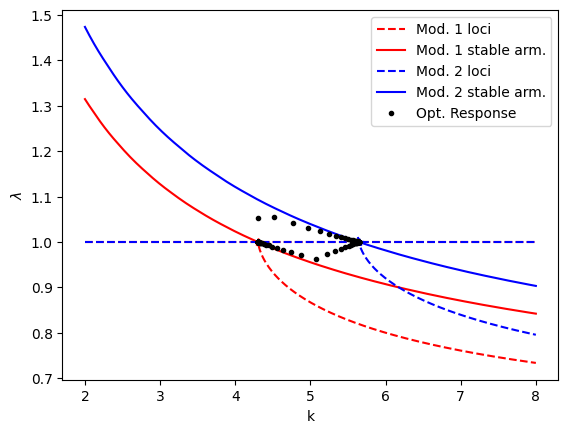

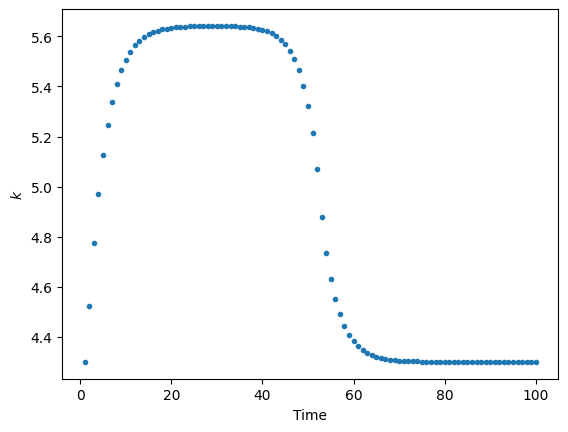

In [10]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_psi = deepcopy(Qmodel)
Q_high_psi.psi = psi_high
Q_high_psi.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# and the new one "Q_high_psi", and store the plot in
# object "ax"
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_psi, k_min = 2, k_max = 8)

# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')